<a href="https://colab.research.google.com/github/hien25661/MachineLearningModel/blob/main/ImageDirectionDetection(DNN)_New_WithLoadModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Direction Detection
- Problem : detect whether a given input image is correctly direction. 
 + Positive sample: not rotated/flipped, correctly oriented, `label=1`. 
 + Modified data to be a negative sample (flipped/rotated, `label=0`).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import datetime

## 1.Load Dataset

In [ ]:
# Loading raw
TRAIN_VAL_SPLIT = 0.15
SEED = 1337
IMG_SIZE = (256, 256)
BATCH = 16

###1.1 Pre-processing and Splitting

#### a, Copy dataset

In [ ]:
# Image data preprocessing
raw_dataset_train = tf.keras.utils.image_dataset_from_directory(
    directory="/content/drive/MyDrive/MachineMags/ImageDirection/Data/Images",
    labels=None, crop_to_aspect_ratio=True, seed=SEED, image_size=IMG_SIZE,
    validation_split=TRAIN_VAL_SPLIT, subset="training", batch_size=BATCH)
raw_dataset_val = tf.keras.utils.image_dataset_from_directory(
    directory="/content/drive/MyDrive/MachineMags/ImageDirection/Data/Images",
    labels=None, crop_to_aspect_ratio=True, seed=SEED, image_size=IMG_SIZE,
    validation_split=TRAIN_VAL_SPLIT, subset="validation", batch_size=BATCH)

Found 5295 files belonging to 1 classes.
Using 4501 files for training.
Found 5295 files belonging to 1 classes.
Using 794 files for validation.


#### b, Splitting Dataset with label to each class

In [ ]:
@tf.function
def add_modifications_and_labels(image_batch):
    batch_size = tf.shape(image_batch)[0]
    print('batch_size:' + str(batch_size))
    flipped_images = tf.image.flip_up_down(image_batch)

    rotated_images = tf.image.rot90(image_batch, k=1)
    print('rotated_images:' + str(rotated_images))
    original_label = tf.ones([batch_size], dtype=tf.bool)
    print('original_label:' + str(original_label))
    modified_label = tf.zeros([batch_size], dtype=tf.bool)
    print('modified_label:' + str(modified_label))

    # Concatenate flipped/rotated images and original/modified labels to the dataset
    image_batch = tf.concat([image_batch, flipped_images, rotated_images], 0)
    labels = tf.cast(tf.concat([original_label, modified_label, modified_label], 0), tf.int32)

    return image_batch, labels

dataset_train = raw_dataset_train.map(add_modifications_and_labels, num_parallel_calls=tf.data.AUTOTUNE)
dataset_val = raw_dataset_val.map(add_modifications_and_labels, num_parallel_calls=tf.data.AUTOTUNE)

batch_size:Tensor("strided_slice:0", shape=(), dtype=int32)
rotated_images:Tensor("rot90/cond/Identity:0", shape=(None, 256, 256, 3), dtype=float32)
original_label:Tensor("ones:0", shape=(None,), dtype=bool)
modified_label:Tensor("zeros:0", shape=(None,), dtype=bool)


#### b, Dataset visually

tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0], shape=(48,), dtype=int32)


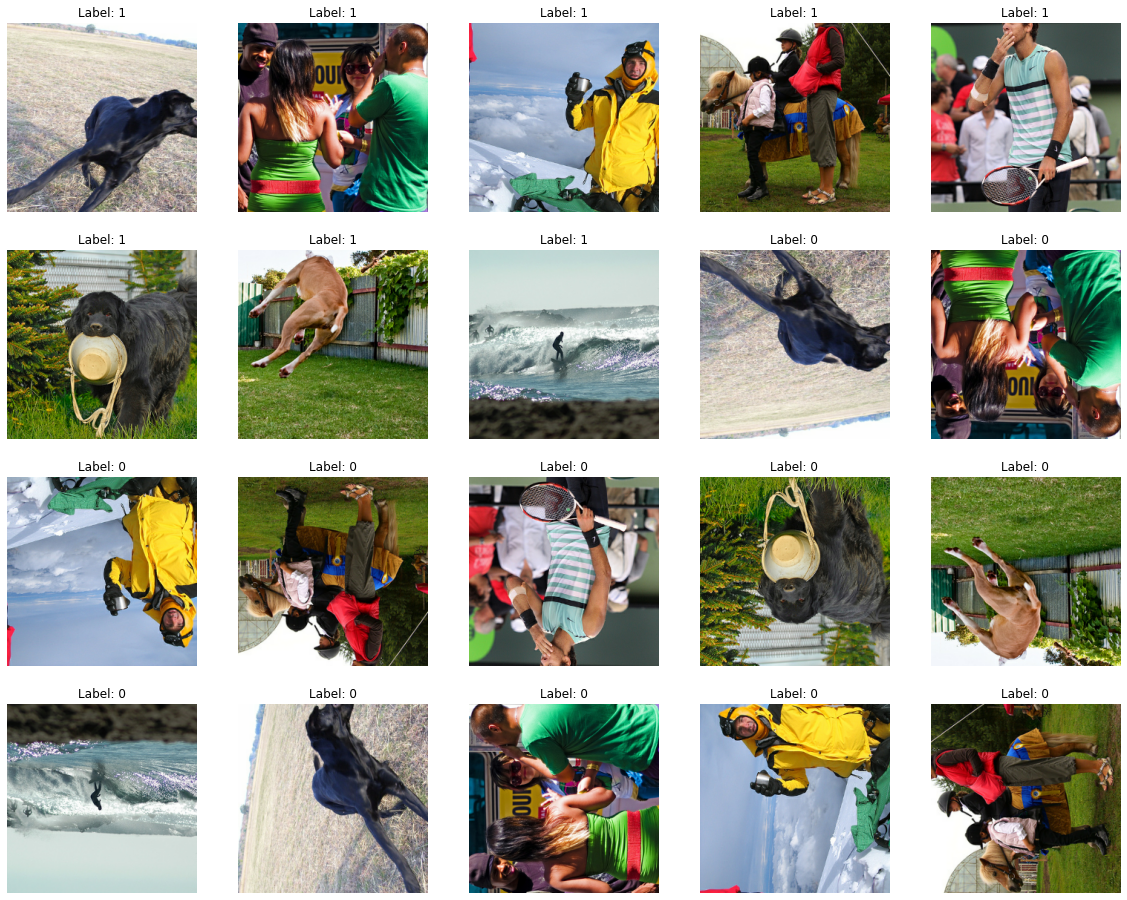

In [ ]:
def plot_images_and_labels(batch, predictions=None, stride=1, rows=4, cols=5):
    plt.figure(figsize=(4 * cols, 4 * rows))
    for images, labels in batch:
        print(labels)
        for i in range(rows * cols):
            ax = plt.subplot(rows, cols, i + 1)
            # display every nth image in the batch
            idx = stride * i
            image = images[idx]
            label = labels[idx].numpy()
            plt.imshow(image.numpy().astype("uint8"))
            title = "Label: " + str(label)
            title_color = 'black'
            if predictions is not None:
                prediction = predictions[idx]
                title += f", Pred: {prediction:.2f}"
                error = np.abs(label - prediction)
                if error > 0.5:
                    title_color = 'red'
            plt.title(title, color=title_color)
            plt.axis("off")
        break
    plt.show()

plot_images_and_labels(dataset_train.take(1), stride=2)

# 2. Train a Model
### Use a base model trained on ImageNet without head and apply transfer learning to fine-tune for this problem. We will use DNN Model

In [ ]:
# Load Pre-Trained Model EfficientNetB0
base_model = tf.keras.applications.efficientnet.EfficientNetB0(weights="imagenet", include_top=False,
                                                               input_tensor=tf.keras.layers.Input(shape=(225, 225, 3)))

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
])

base_model.summary()

model = tf.keras.Sequential([
    base_model,
    data_augmentation,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss=tf.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(), 'AUC', 'accuracy'])
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['normalization[0][0

## Model Training 
#### Train model with 30 epochs

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

epochs = 30;
history = model.fit(
    dataset_train,
    validation_data=dataset_val,
    epochs=epochs,
    callbacks=[tensorboard_callback]
)

model.save('/content/drive/MyDrive/MachineMags/ImageDirection/img_orientation_detector_v1.h5')

282/282 [==============================] - 52s 183ms/step - loss: 0.1118 - binary_accuracy: 0.9565 - auc: 0.9903 - accuracy: 0.9565 - val_loss: 0.1779 - val_binary_accuracy: 0.9379 - val_auc: 0.9772 - val_accuracy: 0.9379
Epoch 27/30
282/282 [==============================] - 56s 197ms/step - loss: 0.1144 - binary_accuracy: 0.9555 - auc: 0.9900 - accuracy: 0.9555 - val_loss: 0.2200 - val_binary_accuracy: 0.9215 - val_auc: 0.9761 - val_accuracy: 0.9215
Epoch 28/30
282/282 [==============================] - 56s 198ms/step - loss: 0.1083 - binary_accuracy: 0.9576 - auc: 0.9909 - accuracy: 0.9576 - val_loss: 0.1903 - val_binary_accuracy: 0.9249 - val_auc: 0.9777 - val_accuracy: 0.9249
Epoch 29/30
282/282 [==============================] - 56s 198ms/step - loss: 0.1049 - binary_accuracy: 0.9603 - auc: 0.9914 - accuracy: 0.9603 - val_loss: 0.1884 - val_binary_accuracy: 0.9379 - val_auc: 0.9744 - val_accuracy: 0.9379
Epoch 30/30
282/282 [==============================] - 56s 198ms/step - loss

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

## Prediction

64
64
2/2 [==============================] - 2s 21ms/step
tf.Tensor(
[1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0], shape=(64,), dtype=int32)


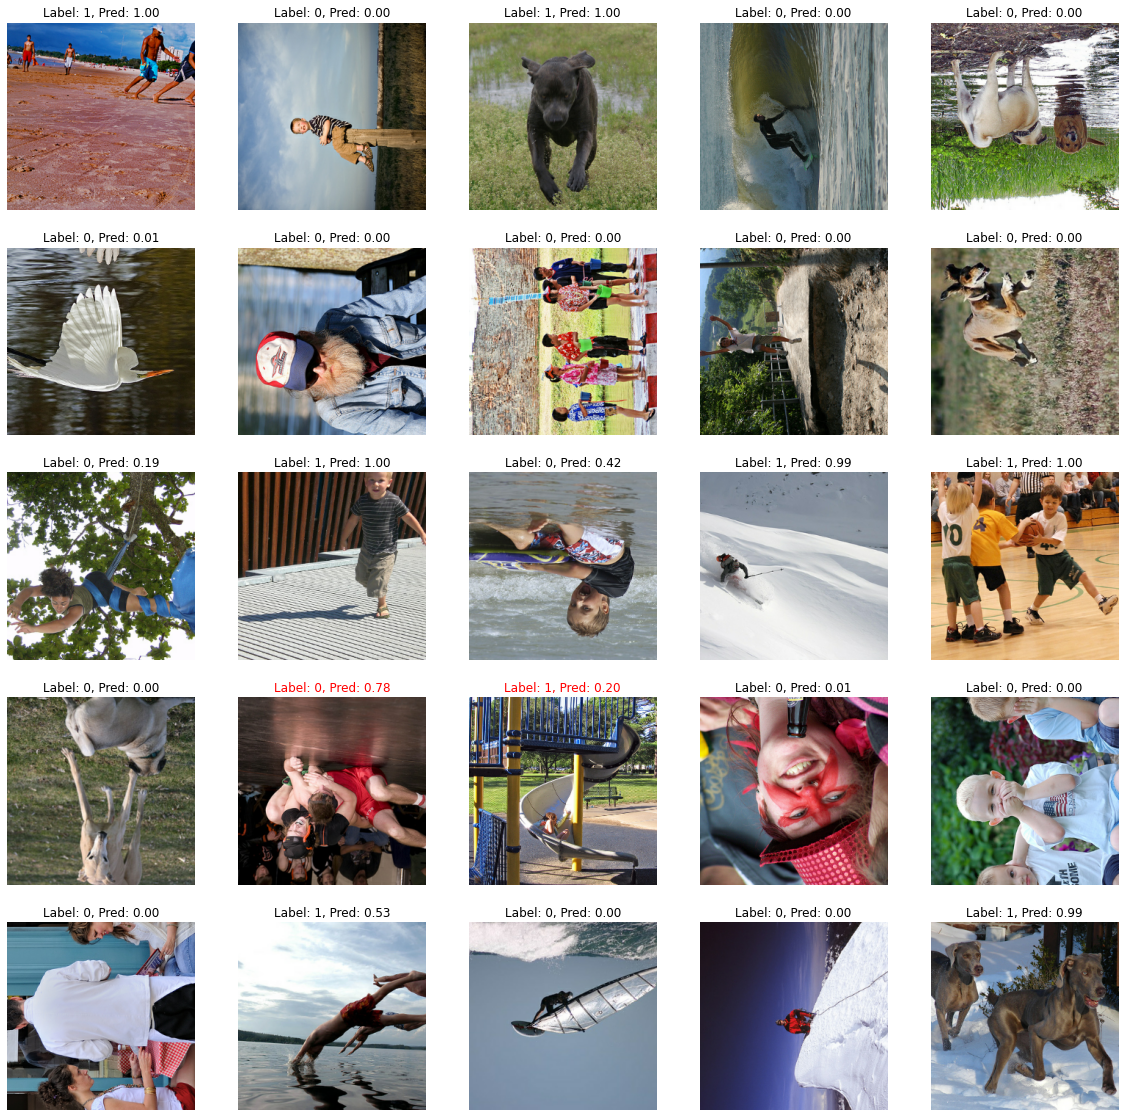

In [ ]:
#sampled_images, sampled_labels = dataset_val.shuffle(1024).get_single_element()
sampled_images, sampled_labels = dataset_val.unbatch().shuffle(1024).batch(64).take(1).get_single_element()


print(len(sampled_images))
print(len(sampled_labels))

predictions = model.predict(sampled_images)
#
plot_images_and_labels([(sampled_images, sampled_labels)], predictions.squeeze(), stride=1, rows=5)

# 3. Evaluation
### Get Final Accuracy value

In [ ]:
res = model.evaluate(dataset_val)

50/50 [==============================] - 6s 116ms/step - loss: 0.2101 - binary_accuracy: 0.9257 - auc: 0.9756 - accuracy: 0.9257


###Visually the Training Result, Evaluation Metric

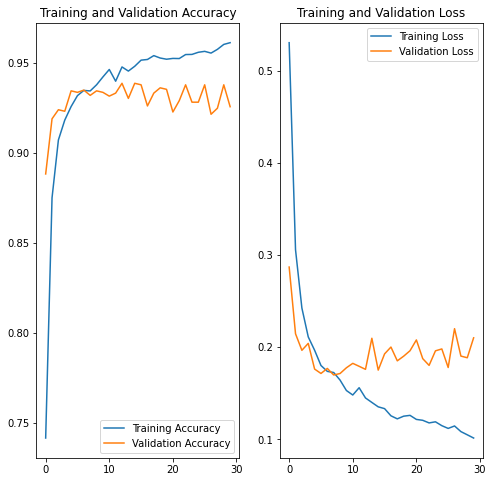

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Test a exported Model

In [3]:
import cv2

In [ ]:
PATH_TO_MODEL = '/content/drive/MyDrive/MachineMags/ImageDirection/img_orientation_detector_v1.h5'


img_direction_model = tf.keras.models.load_model(PATH_TO_MODEL)

input_img = cv2.imread("geeksforgeeks.png", cv2.IMREAD_COLOR)

# input image size
width = 256
height = 256
dim = (width, height)

plt.figure(figsize=(4, 4))



# resize image
resized = cv2.resize(face, dim)
image_tensor = tf.convert_to_tensor(resized)
# reshaped_tensor = tf.reshape(image_tensor, (1, 225, 225, 3))
image_tensor = image_tensor[tf.newaxis, ...]
print(image_tensor.shape)

prediction = classfify_fn_image_face_cut.predict(image_tensor)
print(prediction)
plt.subplot(5, 5, index + 1)
plt.title(str(prediction[0][0]))
plt.imshow(resized)
plt.show()

In [ ]:
PATH_TO_MODEL = '/content/drive/MyDrive/MachineMags/ImageDirection/img_orientation_detector_v1.h5'


img_direction_model = tf.keras.models.load_model(PATH_TO_MODEL)

input_img = cv2.imread("geeksforgeeks.png", cv2.IMREAD_COLOR)

# input image size
width = 256
height = 256
dim = (width, height)

plt.figure(figsize=(4, 4))



# resize image
resized = cv2.resize(face, dim)
image_tensor = tf.convert_to_tensor(resized)
# reshaped_tensor = tf.reshape(image_tensor, (1, 225, 225, 3))
image_tensor = image_tensor[tf.newaxis, ...]
print(image_tensor.shape)

prediction = classfify_fn_image_face_cut.predict(image_tensor)
print(prediction)
plt.subplot(5, 5, index + 1)
plt.title(str(prediction[0][0]))
plt.imshow(resized)
plt.show()

(1, 225, 225, 3)
1/1 [==============================] - 4s 4s/step
[[0.9997756]]


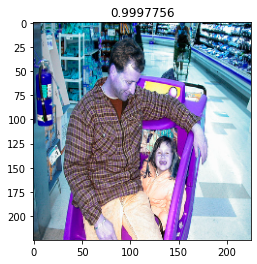

In [7]:
PATH_TO_MODEL = '/content/drive/MyDrive/MachineMags/ImageDirection/img_orientation_detector_v1.h5'


img_direction_model = tf.keras.models.load_model(PATH_TO_MODEL)

input_img = cv2.imread("/content/drive/MyDrive/MachineMags/ImageDirection/correct.png", cv2.IMREAD_COLOR)

# input image size
width = 225
height = 225
dim = (width, height)

plt.figure(figsize=(4, 4))



# resize image
resized = cv2.resize(input_img, dim)
image_tensor = tf.convert_to_tensor(resized)
image_tensor = image_tensor[tf.newaxis, ...]
print(image_tensor.shape)

prediction = img_direction_model.predict(image_tensor)
print(prediction)
plt.title(str(prediction[0][0]))
plt.imshow(resized)
plt.show()